# Methods of De-treding
This notebook outllines different methods that can be used to de-trend the LongRunMIP and ZECMIP time series.

In [3]:
import nc_time_axis
import warnings

import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload
import string


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec 
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

import os
import sys

from numpy.typing import ArrayLike
from typing import Optional, Callable, List, Tuple, Dict

warnings.filterwarnings('ignore')

In [5]:
import constants
sys.path.append(constants.MODULE_DIR)
import sn_plotting as sn_plot
import xarray_class_accessors as xca
import utils
import stats
import xarray_extender as xce
import signal_to_noise as sn
import open_ds
from classes import ExperimentTypes, LocationsLatLon

logger = utils.get_notebook_logger()

In [6]:
notebook_number='02'

In [7]:
import dask.distributed as dd
import tempfile

tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dd.Client(local_directory=tempdir.name, memory_limit='16gb')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43979/status,
Dashboard: http://127.0.0.1:43979/status,Workers: 4
Total threads: 16,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40379,Workers: 4
Dashboard: http://127.0.0.1:43979/status,Total threads: 16
Started: Just now,Total memory: 59.60 GiB
Comm: tcp://127.0.0.1:42819,Total threads: 4
Dashboard: http://127.0.0.1:44073/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:39503,


# Loading Data

In [8]:
experiment_params = constants.EXPERIMENTS_TO_RUN[0]

## ZECMIP

In [9]:
experiment_zec_ds = xr.open_mfdataset(os.path.join(
    constants.ZECMIP_LOCAL_DIR, 'regridded', '4xCO2', '*.nc')).compute()

picontrol_zec_ds = xr.open_mfdataset(
    os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'picontrol', '*.nc'), 
                  use_cftime=True, concat_dim='model', combine='nested').compute()
experiment_zec_ds

<xarray.Dataset>
Dimensions:  (time: 330, lat: 96, lon: 192, model: 8)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0330-12-31 00:00:00
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * model    (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height   float64 2.0
Data variables:
    tas      (time, model, lat, lon) float32 228.2 228.1 228.0 ... 265.1 265.1

In [10]:
experiment_zec_ds_smean, picontrol_zec_ds_smean = sn.calculate_global_value(
    experiment_zec_ds, picontrol_zec_ds,experiment_params["variable"])

(None, None)
tas, 

## Abrupt 4x

In [11]:
reload(open_ds)

<module 'open_ds' from '/home/563/ab2313/Documents/PhD/modules/open_ds.py'>

In [12]:
control_abrupt_ds = open_ds.open_experiment_files(experiment_params, ExperimentTypes.CONTROL)
abrupt4x_ds = open_ds.open_experiment_files(experiment_params, ExperimentTypes.ABRUPT4X)



- /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped=
- Opening files in /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped
- Time lengths
- --- Running function 'read_longrunmip_netcdf'
- Opening files /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped/tas_mon_CCSM3_control_1530_g025.nc
- requested_length=100
- Removing first 10 steps
- Converting from Kelvin to C
- tas_mon_CCSM3_control_1530_g025.nc - 1520
- --- Running function 'read_longrunmip_netcdf'
- Opening files /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped/tas_mon_CESM104_control_1000_g025.nc
- requested_length=100
- Rename var='tas' to cesm104
- Converting from Kelvin to C
- tas_mon_CESM104_control_1000_g025.nc - 1000
- --- Running function 'read_longrunmip_netcdf'
- Opening files /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped/tas_mon_CNRMCM61_control_2000_g025.nc
- requested_length=100
- Rename var='tas' to cnrmcm61
- Converting from Kelvin to C
- tas_mon_CNRMCM61_control_2

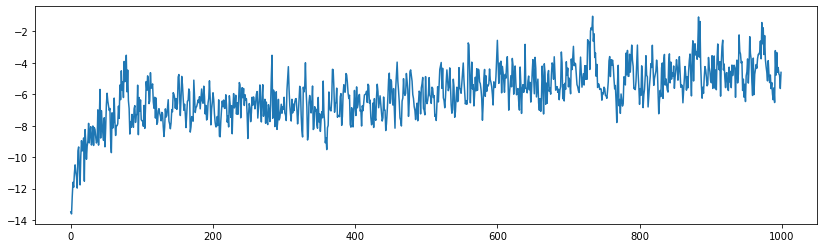

In [16]:
fig = plt.figure(figsize=(14,4))
plt.plot(abrupt4x_ds.isel(lat=-1, lon=0).ccsm3.values)

# Calculations

## Data Selection

In [17]:
PROFILE_SELECTOR_DICT = {
    'zec': {
        'global': {'pi': picontrol_zec_ds_smean.tas, 'exp': experiment_zec_ds_smean.tas},
        'local': {'pi': picontrol_zec_ds.tas, 'exp': experiment_zec_ds.tas}},
    'abrupt': {
        'global': {'pi': control_abrupt_ds_smean.to_array(dim='model'),
                   'exp': abrupt4x_ds_smean.to_array(dim='model')},
        'local': {'pi': control_abrupt_ds.to_array(dim='model'),
                  'exp': abrupt4x_ds.to_array(dim='model')}}}

In [18]:
profile = 'abrupt' # abrupt zec
region = 'local' #  global local
model1 = 'ccsm3'
model2 = 'CESM2'

In [19]:
experiment_da = PROFILE_SELECTOR_DICT[profile][region]['exp']
picontrol_da = PROFILE_SELECTOR_DICT[profile][region]['pi']

## Execution

In [20]:
import zarr

In [471]:
stats.trend_fit(test_da, method='polynomial', order=6)

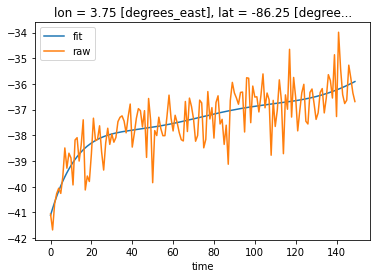

In [472]:
test_fit.isel(model=1, lat=1, lon=1).plot(label='fit')
test_da.isel(model=1, lat=1, lon=1).plot(label='raw')
plt.legend()